# Digit Recognizer
## Kaggle Competition - Baptiste Lemaire


### Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.layers import Conv2D, InputLayer, AveragePooling2D, Dense, Flatten, ZeroPadding2D, Activation
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorboard import notebook
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy

### Data preprocessing

In [2]:
ds = np.loadtxt("data/train.csv", dtype=int, delimiter=',', skiprows=1)
y = ds[:,0]
X = ds[:,1:]

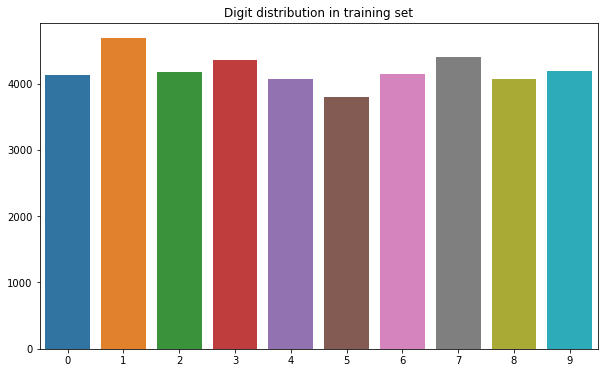

In [3]:
digit_distr = {i:np.count_nonzero(y == i) for i in range(10)}

plt.figure(figsize=(10,6))
plt.title("Digit distribution in training set")
sns.barplot(x=list(digit_distr.keys()), y=list(digit_distr.values()))
plt.show()

Distribution is well balanced. Therefore, we shouldn't have problem during the training about disproportionate distribution.

In [4]:
def plot_matrix_grid(V):
    """
    Given an array V containing stacked matrices, plots them in a grid layout.
    V should have shape (K,M,N) where V[k] is a matrix of shape (M,N).
    """
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmin, vmax = np.percentile(V, [0.1, 99.9])   # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=vmin, vmax=vmax, cmap=plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right
    plt.show()

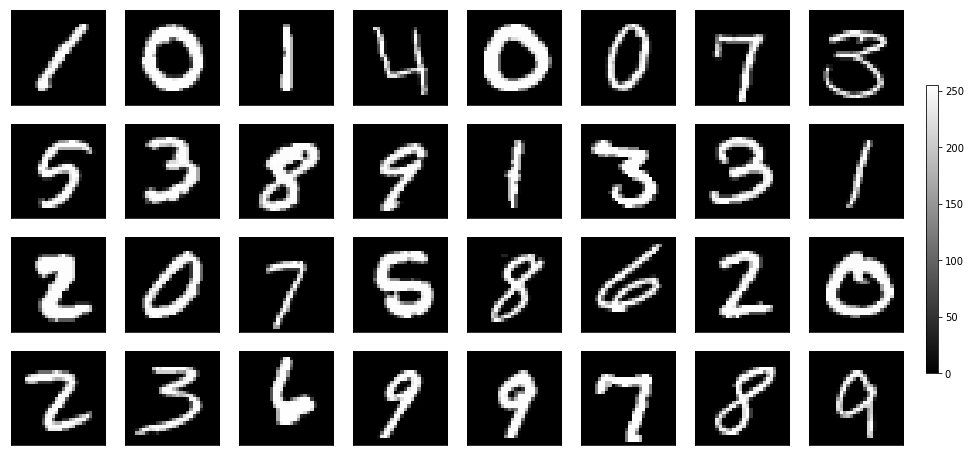

In [5]:
plot_matrix_grid(np.reshape(X, (X.shape[0], 28, 28)))

In [6]:
# Preprocessing training set

scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scl = scaler.transform(X)

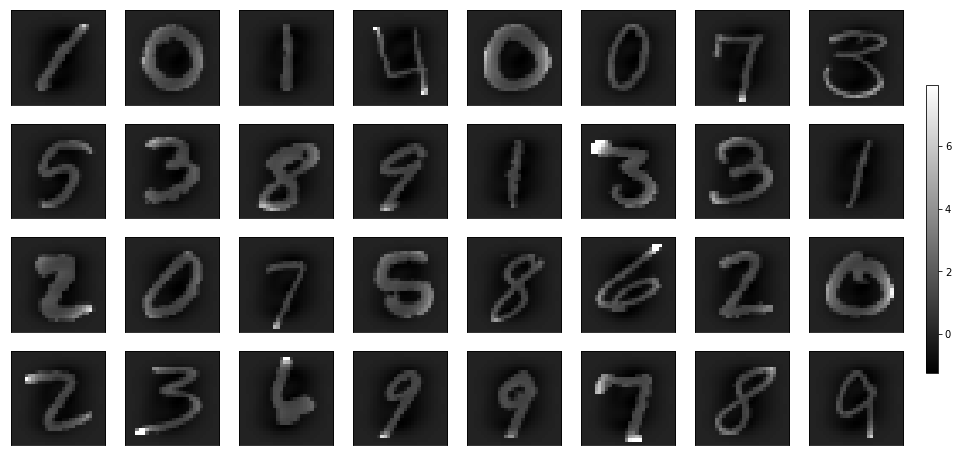

In [7]:
plot_matrix_grid(np.reshape(X_scl, (X_scl.shape[0], 28, 28)))

In [8]:
X_scl_rs = np.reshape(X_scl, (ds.shape[0], 28, 28)) # reshape the whole dataset
X_train, X_test, y_train, y_test = train_test_split(X_scl_rs, y, train_size=0.8, random_state=0)

### CNN model - Lenet-5

In [9]:
clear_session()

lenet_model = Sequential([
    InputLayer(input_shape=(28, 28, 1), name="Input"),
    ZeroPadding2D((2, 2)),
    Conv2D(6, 5, strides=1, padding='valid', activation='tanh'),
    AveragePooling2D((2,2), strides=2),
    Conv2D(16, 5, strides=1, padding='valid', activation='tanh'),
    AveragePooling2D((2,2), strides=2),
    Conv2D(120, 5, strides=1, padding='valid', activation='tanh'),
    Flatten(),  
    Dense(84, activation='tanh'), 
    Dense(10),
    Activation("softmax")
],name="lenet_model")
lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 32, 32, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                       

In [10]:
%%time
# earlystopping = EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # path for tensorboards logs
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1) #tensorboard callback function
 

lenet_model.compile(optimizer=SGD(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['acc'])

lenet_model.fit(
    X_train,
    y_train,
    epochs=200, 
    callbacks=[tensorboard],
    validation_data = (X_test, y_test)
   
)

save_model(lenet_model, lenet_model.name+".h5")

Epoch 1/200
1050/1050 [==============================] - 8s 8ms/step - loss: 0.6613 - acc: 0.8374 - val_loss: 0.3572 - val_acc: 0.9025
Epoch 2/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.3201 - acc: 0.9072 - val_loss: 0.2840 - val_acc: 0.9198
Epoch 3/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.2630 - acc: 0.9231 - val_loss: 0.2443 - val_acc: 0.9304
Epoch 4/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.2248 - acc: 0.9331 - val_loss: 0.2121 - val_acc: 0.9388
Epoch 5/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.1930 - acc: 0.9429 - val_loss: 0.1894 - val_acc: 0.9448
Epoch 6/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.1676 - acc: 0.9505 - val_loss: 0.1666 - val_acc: 0.9529
Epoch 7/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.1461 - acc: 0.9574 - val_loss: 0.1485 - val_acc: 0.9569
Epoch 8/200
1050/1050 [==============================] 

1050/1050 [==============================] - 8s 7ms/step - loss: 0.0114 - acc: 0.9979 - val_loss: 0.0466 - val_acc: 0.9854
Epoch 62/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0110 - acc: 0.9983 - val_loss: 0.0467 - val_acc: 0.9854
Epoch 63/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0108 - acc: 0.9984 - val_loss: 0.0460 - val_acc: 0.9860
Epoch 64/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0105 - acc: 0.9983 - val_loss: 0.0468 - val_acc: 0.9856
Epoch 65/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0102 - acc: 0.9985 - val_loss: 0.0478 - val_acc: 0.9848
Epoch 66/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0099 - acc: 0.9984 - val_loss: 0.0461 - val_acc: 0.9857
Epoch 67/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0097 - acc: 0.9985 - val_loss: 0.0456 - val_acc: 0.9864
Epoch 68/200
1050/1050 [==============================] - 8s 

1050/1050 [==============================] - 8s 7ms/step - loss: 0.0030 - acc: 0.9999 - val_loss: 0.0472 - val_acc: 0.9863
Epoch 122/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0029 - acc: 0.9999 - val_loss: 0.0475 - val_acc: 0.9864
Epoch 123/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0029 - acc: 0.9999 - val_loss: 0.0475 - val_acc: 0.9863
Epoch 124/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0028 - acc: 0.9999 - val_loss: 0.0473 - val_acc: 0.9861
Epoch 125/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0028 - acc: 0.9999 - val_loss: 0.0481 - val_acc: 0.9862
Epoch 126/200
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0479 - val_acc: 0.9863
Epoch 127/200
1050/1050 [==============================] - 9s 8ms/step - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0475 - val_acc: 0.9861
Epoch 128/200
1050/1050 [==============================

Epoch 181/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0500 - val_acc: 0.9863
Epoch 182/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0501 - val_acc: 0.9862
Epoch 183/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0500 - val_acc: 0.9863
Epoch 184/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 0.9860
Epoch 185/200
1050/1050 [==============================] - 9s 8ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0504 - val_acc: 0.9865
Epoch 186/200
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0500 - val_acc: 0.9867
Epoch 187/200
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0505 - val_acc: 0.9863
Epoch 188/200
1050/1050 [================

### Test

In [11]:
# Accuracy on the whole training set
model = load_model("lenet_model.h5")

output = model.predict(X_scl_rs)
prediction = np.argmax(output, axis=1)

print(f"Accuracy: {accuracy_score(y, prediction)*100}%")

Accuracy: 99.72619047619048%


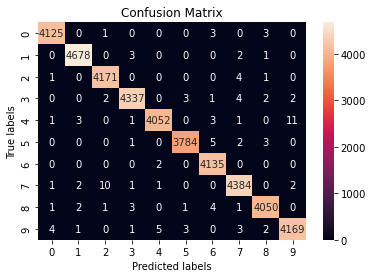

In [16]:
# Confusion matrix
cm = confusion_matrix(y, prediction)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(range(0,10)))
ax.yaxis.set_ticklabels(list(range(0,10)));

### Submission 

In [13]:
test_X = np.loadtxt("data/test.csv", dtype=int, delimiter=',', skiprows=1)
test_X_scl = scaler.transform(test_X)
test_X_scl_rs = np.reshape(test_X_scl, (test_X_scl.shape[0], 28, 28))

In [14]:
model = load_model("lenet_model.h5")

test_output = model.predict(test_X_scl_rs)
test_prediction = np.argmax(test_output, axis=1)

In [15]:
with open("my_submission.csv", "w") as f:
    f.write("ImageId,Label\n")
    for i, pred in enumerate(test_prediction):
        f.write(f"{i+1},{pred}\n")

On Kaggle, I ended up with a 98.7% accuracy. Compared to the training set accuracy, I lost 1%. Thus, my model overfits a little the training set.

To increase the score, I can use a bigger and more complex model. 

I wanted to use Lenet-5 for its simplicity. I trained the model for 200 epochs. It took only 26 minutes, even without GPU acceleration (CUDA, Google Colab, ...). Therefore, it would be easy to have a better score. I can create my own structure or use a better one such as Boosted Lenet-4.

I used Sci-kit Learn preprocessing function. It could interesting to explore and use another preprocessing method.